In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, Conv2D, InputLayer, BatchNormalization, Flatten, MaxPool2D, Dropout, Dense, RandomRotation, RandomFlip, RandomContrast, Input
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras.models import Model


from sklearn.metrics import confusion_matrix, roc_curve### metrics


import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns

## **FETCHING DATA FROM KAGGLE**

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/tensorflow-computer-vision/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes --force

 95% 295M/309M [00:02<00:00, 124MB/s]
100% 309M/309M [00:02<00:00, 113MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

## **DATASET LOADING**

In [ ]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
val_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

### **CREATING TRAINING DATA**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


### **CREATING VALIDATION DATA**

In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


## **DATASET VISUALISATION**

In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

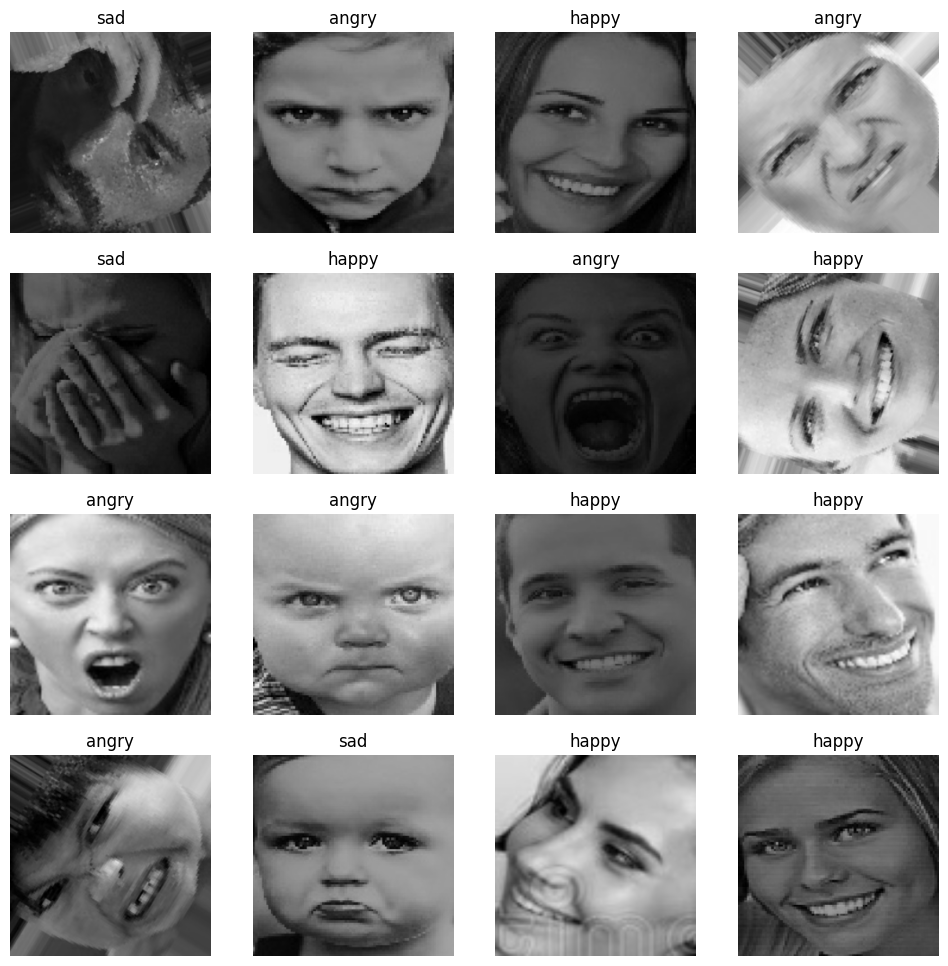

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## **DATASET AUGMENTATION**

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

## **DATASET PREPARATION**

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
val_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

### **CREATING RESIZE AND RESCALE LAYERS FOR MODEL**

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

## **MODELLING**

### **LENET MODEL**

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(
        filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"],
        strides = CONFIGURATION["N_STRIDES"] , padding='valid',
        activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])
    ),

    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(
        filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"],
        strides=CONFIGURATION["N_STRIDES"], padding='valid',
        activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])
    ),

    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu",
          kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])
    ),

    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu",
          kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])
    ),

    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

### **TRANSFER LEARNING USING EFFICIENTNET**

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

In [ ]:
backbone.trainable = False

In [ ]:
from keras.layers import GlobalAveragePooling2D
model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu'),
    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax'),
])

model.summary()

### **VISION TRANSFORMER**

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


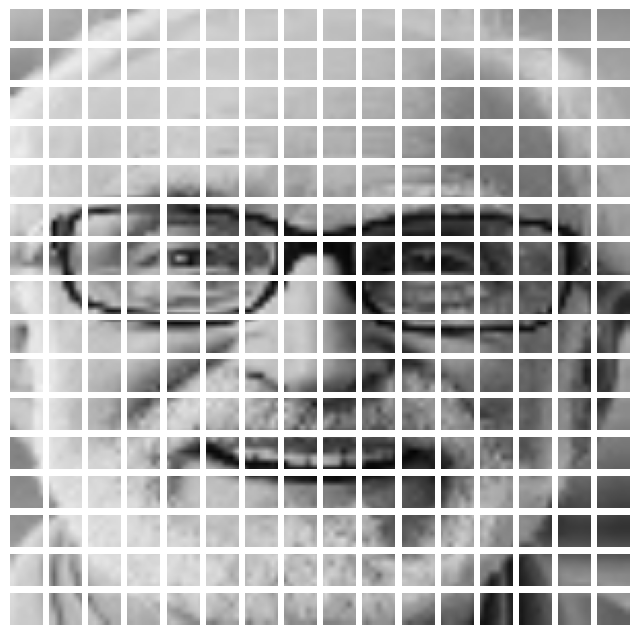

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

### **TRANSFORMER ENCODER**

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

### **VISION TRANSFORMER MODEL**

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

vit.summary()

## **MODEL TRAINING**

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 106s 392ms/step - loss: 0.8105 - accuracy: 0.6904 - top_k_accuracy: 0.8962 - val_loss: 0.6513 - val_accuracy: 0.7169 - val_top_k_accuracy: 0.9126
Epoch 2/20
213/213 [==============================] - 72s 337ms/step - loss: 0.5797 - accuracy: 0.7592 - top_k_accuracy: 0.9323 - val_loss: 0.5548 - val_accuracy: 0.7629 - val_top_k_accuracy: 0.9289
Epoch 3/20
213/213 [==============================] - 74s 344ms/step - loss: 0.4961 - accuracy: 0.7894 - top_k_accuracy: 0.9469 - val_loss: 0.5585 - val_accuracy: 0.7748 - val_top_k_accuracy: 0.9267
Epoch 4/20
213/213 [==============================] - 73s 342ms/step - loss: 0.4587 - accuracy: 0.8129 - top_k_accuracy: 0.9507 - val_loss: 0.4876 - val_accuracy: 0.7976 - val_top_k_accuracy: 0.9394
Epoch 5/20
213/213 [==============================] - 84s 391ms/step - loss: 0.4328 - accuracy: 0.8231 - top_k_accuracy: 0.9584 - val_loss: 0.5176 - val_accuracy: 0.7910 - val_top_k_accuracy: 0.9377
Epoc

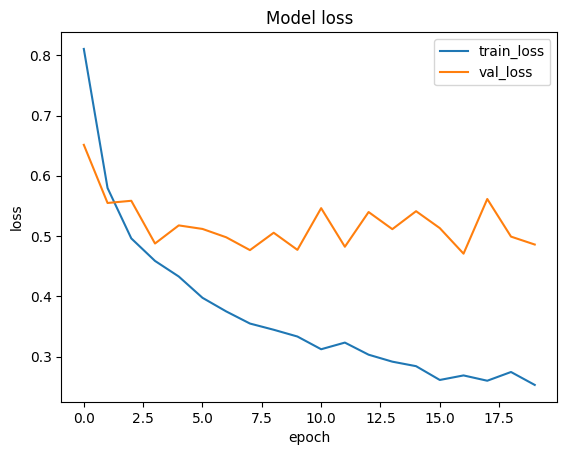

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

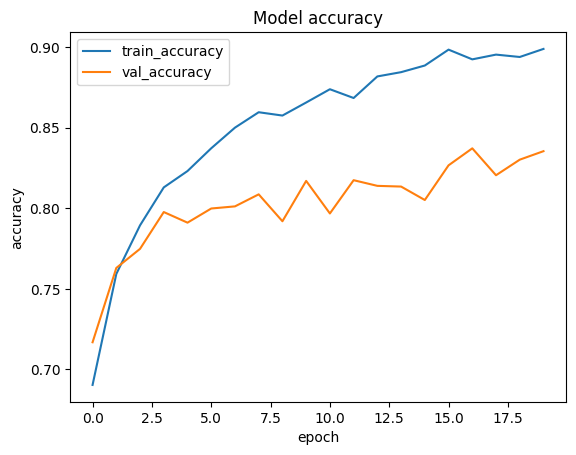

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## **MODEL EVALUATION**

In [ ]:
lenet_model.evaluate(val_dataset)

72/72 [==============================] - 5s 56ms/step - loss: 1.5289 - accuracy: 0.6962 - top_k_accuracy: 0.8740


[1.5289201736450195, 0.6962247490882874, 0.874012291431427]

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(lenet_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

tf.Tensor([[0.04565629 0.25066987 0.7036738 ]], shape=(1, 3), dtype=float32)
sad


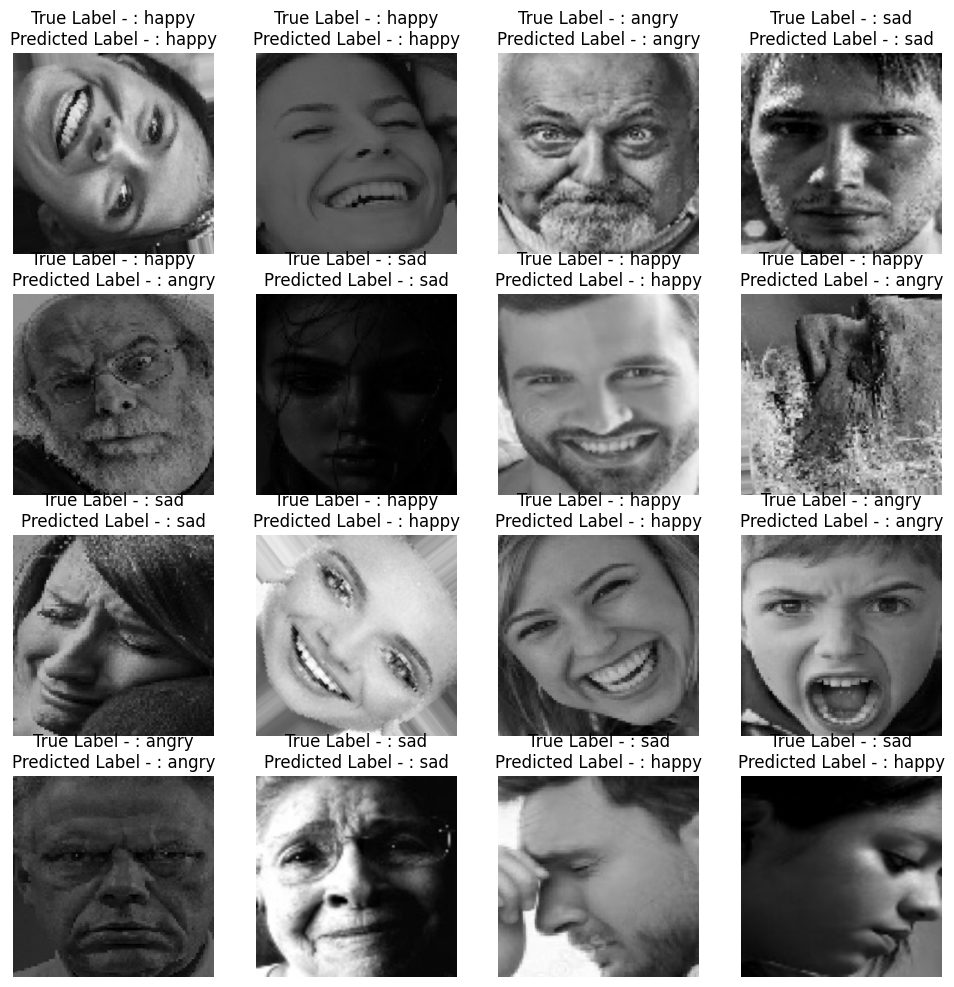

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

### **CONFUSION MATRIX**

In [ ]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 1 1 2]
[1 1 2 ... 1 0 2]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[310 148  57]
 [ 60 881  65]
 [ 97 265 395]]


Text(0.5, 58.7222222222222, 'Predicted')

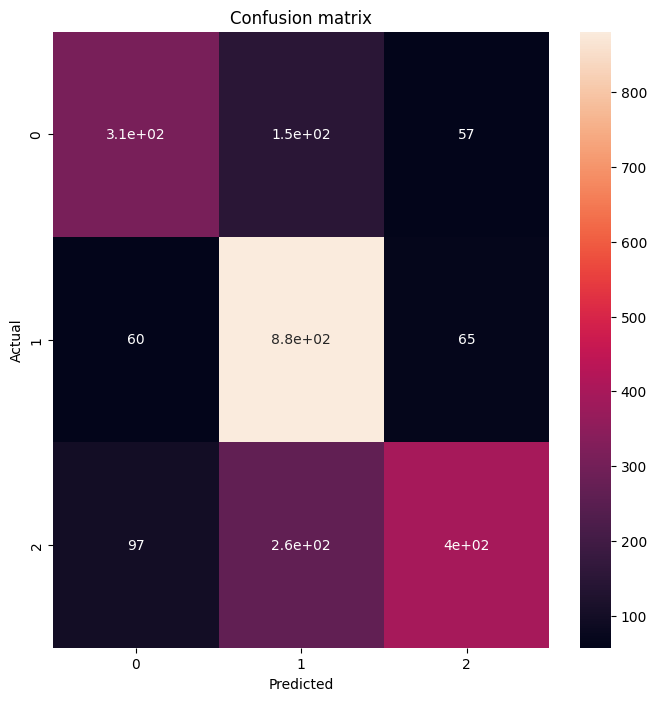

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## **VISUALISATION**

### **FEATURE MAP VISUALISATION**

In [ ]:
# function to check if a layer is convolutional layer

def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 8s 8s/step


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")
